In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
import random
from pathlib import Path

In [17]:
# Загрузка конфигурации
def load_config(yaml_path=r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\data.yaml"):
    with open(yaml_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

config = load_config()
class_names = config['names']
print("Доступные классы:", class_names)

# Цвета для разных классов
class_colors = {
    0: (255, 0, 0),    # красный - elbow positive
    1: (0, 255, 0),    # зеленый - fingers positive
    2: (0, 0, 255),    # синий - forearm fracture
    3: (255, 255, 0),  # голубой - humerus fracture
    4: (255, 0, 255),  # фиолетовый - humerus
    5: (0, 255, 255),  # желтый - shoulder fracture
    6: (128, 0, 128)   # пурпурный - wrist positive
}

Доступные классы: ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']


In [19]:
def find_image_paths(base_dir, num_images=20):
 
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    image_paths = []
    
    for extension in image_extensions:
        image_paths.extend(Path(base_dir).rglob(extension))
    
    image_paths = [str(path) for path in image_paths]
    
    if len(image_paths) > num_images:
        image_paths = random.sample(image_paths, num_images)
    
    return image_paths

In [21]:
def find_annotation_path(image_path):
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    
    possible_paths = [
        image_path.replace('.jpg', '.txt').replace('.png', '.txt'),
        image_path.replace('images', 'labels').replace('.jpg', '.txt').replace('.png', '.txt'),
        os.path.join(os.path.dirname(image_path), 'labels', base_name + '.txt'),
        os.path.join(os.path.dirname(os.path.dirname(image_path)), 'labels', base_name + '.txt'),
        os.path.join('labels', base_name + '.txt'),
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            return path
    
    return None

In [23]:
def visualize_images_with_boxes(image_paths, cols=4):

    total_images = len(image_paths)
    rows = (total_images + cols - 1) // cols 
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    

    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, image_path in enumerate(image_paths):
        if idx >= rows * cols:
            break
            
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        
        image = cv2.imread(image_path)
        if image is None:
            ax.text(0.5, 0.5, f"Ошибка загрузки\n{os.path.basename(image_path)}", 
                   ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
            continue
            
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_height, img_width = image_rgb.shape[:2]
        
        txt_path = find_annotation_path(image_path)
        
        if txt_path and os.path.exists(txt_path):
            with open(txt_path, 'r') as file:
                lines = file.readlines()
            
            ax.imshow(image_rgb)
            
            for line in lines:
                line = line.strip()
                if not line:
                    continue
                    
                parts = line.split()
                if len(parts) < 3:
                    continue
                
                try:
                    class_id = int(parts[0])
                    points = []
                    
                    for i in range(1, len(parts), 2):
                        if i + 1 < len(parts):
                            x = float(parts[i]) * img_width
                            y = float(parts[i + 1]) * img_height
                            points.append([x, y])
                    
                    if len(points) < 2:
                        continue
                        
                    points = np.array(points, dtype=np.int32)
                    
                    color = class_colors.get(class_id, (255, 255, 255))
                    color_normalized = [c/255 for c in color]
                    class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                    
                    x_coords = points[:, 0]
                    y_coords = points[:, 1]
                    x_min, x_max = np.min(x_coords), np.max(x_coords)
                    y_min, y_max = np.min(y_coords), np.max(y_coords)
                    width = x_max - x_min
                    height = y_max - y_min
                    
                    rect = plt.Rectangle((x_min, y_min), width, height, 
                                       linewidth=2, edgecolor=color_normalized, 
                                       facecolor='none')
                    ax.add_patch(rect)
                    
                    ax.text(x_min, y_min - 5, class_name, 
                           bbox=dict(boxstyle="round,pad=0.2", facecolor=color_normalized, alpha=0.8),
                           fontsize=8, color='white', fontweight='bold')
                    
                except Exception as e:
                    print(f"Ошибка в {os.path.basename(image_path)}: {e}")
                    continue
                    
            ax.set_title(f'{os.path.basename(image_path)}\n({len(lines)} аннотаций)', fontsize=10)
            
        else:
            ax.imshow(image_rgb)
            ax.set_title(f'{os.path.basename(image_path)}\n(без разметки)', fontsize=10)
        
        ax.axis('off')
    
    for idx in range(len(image_paths), rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

In [25]:
def visualize_specific_images(image_paths_list):
 
    valid_paths = []
    for path in image_paths_list:
        if os.path.exists(path):
            valid_paths.append(path)
        else:
            print(f"❌ Файл не найден: {path}")
    
    if valid_paths:
        print(f"✅ Визуализация {len(valid_paths)} изображений")
        visualize_images_with_boxes(valid_paths)

In [37]:
specific_images = [
    r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_0_png.rf.bc222874fa14e205b638e87ddad52b9d.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_0_png.rf.c864ea1d0d7a6ba347b3bd6fa51bf4c9.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_0_png.rf.c068475415ed98d36b311229ae0d3977.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_0_png.rf.d44c62635f246b717a95453d650ac2cb.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_1_png.rf.9542ae437d2d3ac5c3468a76524a0fda.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_1_png.rf.40707cec7f00c2ad2ec46de477a1bea1.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_1_png.rf.abaa5a569ea9a9ffb5ad2fb32b95958c.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_2_png.rf.64d2ccf3398134c192cbac812aa41c60.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_2_png.rf.a31220d573eb46a9e3dac5c7a6834776.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_3_png.rf.04abd9bceca734c6cc7fee8796d614d6.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_3_png.rf.4f3936b1954ddb019efef8efe3594f6e.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_3_png.rf.555fa5a36b9218a3d4b020bfe09f6d48.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_4_png.rf.5d9d68cfc953c15a810a3051037be25d.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_4_png.rf.386ecf2748b0864228efc9198a8ffeac.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\distal-humeral-fractures-2-_JPEG.rf.39ba3f53047ecb4064613850a1c76fc1.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\distal-humeral-fractures-2-_JPEG.rf.525ce876785d0fd798ec3af1593e5bc1.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\distal-humeral-fractures-2-_JPEG.rf.f9442db05ec473187c60870d407c9e8f.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\elbow-dislocation-with-coronoid-process-fracture_jpg.rf.75b67d2e40fe637ba2838e1283f970c5.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\elbow-dislocation-with-coronoid-process-fracture_jpg.rf.76486fb6ffe2b6c7da0e4922e58a088f.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_0_png.rf.208b9fc171409973fd0f9af79cdcfead.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_2_png.rf.b8485909085469f562b5f4c3332290b7.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_2_png.rf.bdb90c59e63ff64fe00c9b882e588536.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_2_png.rf.e11b6698a3a137e3d96160040051be3a.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_2_png.rf.f146c731a254917918cae26ee9a03748.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_4_png.rf.90544deff0a9ef73bff9997025b85b1d.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_5_png.rf.0da853812ef03abcff9baaea5e91aac4.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_5_png.rf.05c4b7b8b15b0019405c220b665fd5bd.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_5_png.rf.258ebe9f87f5fef0399d85f1b3dfa414.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\elbow-dislocation-with-coronoid-process-fracture_jpg.rf.234153519323ba2b9aa2e603b0a43771.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\fracture-of-the-humeral-capitellum-milch-type-1-1-1-_jpg.rf.4c16d0817782b56497b9f18bca2b0fdd.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\fracture-of-the-humeral-capitellum-milch-type-1-1-1-_jpg.rf.8b022b79c884d0b37d923a3c961591c6.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\fracture-of-the-humeral-capitellum-milch-type-1-1-1-_jpg.rf.f40a3ca2a57d511a40839bd1ca615d54.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_0_png.rf.d48b4a85ca5fc14b889454b188e1b49f.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_1_png.rf.7fc5c56bccb948c1400a182691ed430b.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_1_png.rf.86bfeaf79dab0628174529ab479c8d6d.jpg",
r"D:\Bone_Fracture_Detection_Dataset\BoneFractureYolo8\train\images\image1_1_png.rf.978ebda3070b2fa5d0d53c5465318539.jpg"
]

✅ Визуализация 36 изображений


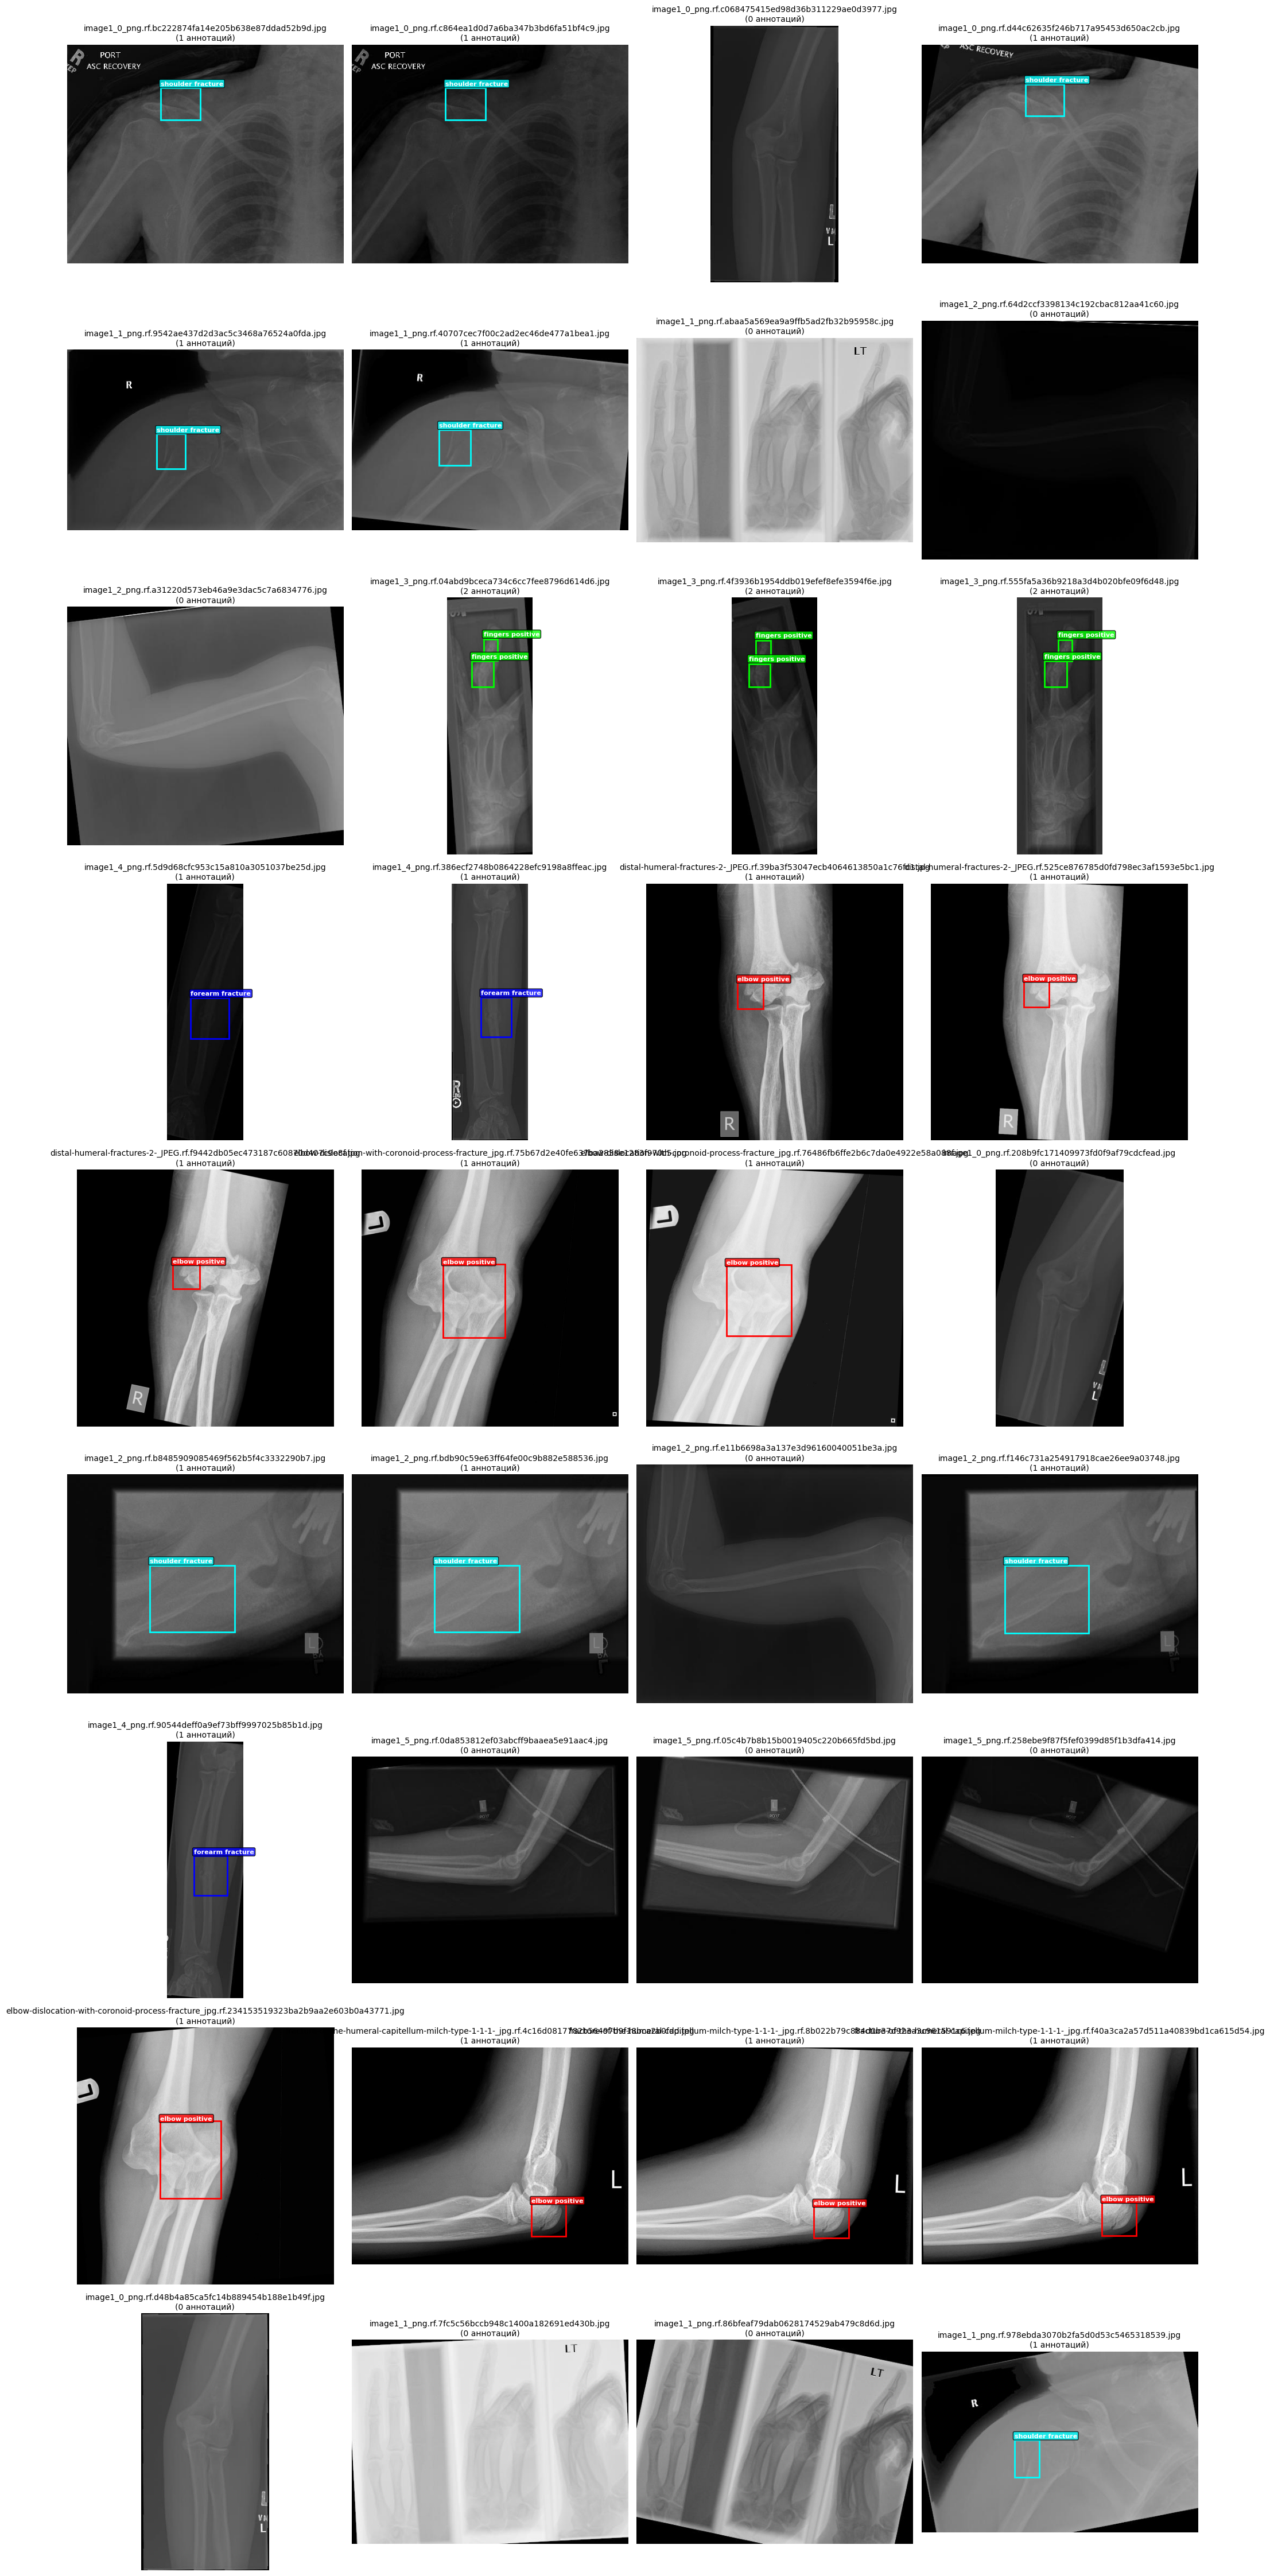

In [39]:
visualize_specific_images(specific_images)